In [44]:
!pip install matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import os
print(os.listdir("partitioned_randomly/images/train")[:5])  # Show a few image names


['r1_Im004.png', 'r2_Im232.png', 'r2_Im018.png', 'r3_G-17-L_left_half.png', 'r2_Im030.png']


In [46]:
import os

print("Images folder contents:")
print(os.listdir("partitioned_randomly/images/train")[:10])

print("\nDisc mask folder contents:")
print(os.listdir("partitioned_randomly/masks_disc/train")[:10])

print("\nCup mask folder contents:")
print(os.listdir("partitioned_randomly/masks_cup/train")[:10])


Images folder contents:
['r1_Im004.png', 'r2_Im232.png', 'r2_Im018.png', 'r3_G-17-L_left_half.png', 'r2_Im030.png', 'r2_Im178.png', 'r1_Im158.png', 'r2_Im352.png', 'r1_Im164.png', 'r2_Im420.png']

Disc mask folder contents:
['r2_Im032-1-Disc-T.png', 'r1_Im132-1-Disc-T.png', 'r2_Im110-1-Disc-T.png', 'r1_Im135-1-Disc-T.png', 'r2_Im292-1-Disc-T.png', 'r2_Im238-1-Disc-T.png', 'r2_Im348-1-Disc-T.png', 'r2_Im102-1-Disc-T.png', 'r1_Im120-1-Disc-T.png', 'r1_Im057-1-Disc-T.png']

Cup mask folder contents:
['r1_Im118-1-Cup-T.png', 'r1_Im087-1-Cup-T.png', 'r1_Im168-1-Cup-T.png', 'r1_Im054-1-Cup-T.png', 'r2_Im369-1-Cup-T.png', 'r1_Im024-1-Cup-T.png', 'r2_Im032-1-Cup-T.png', 'r2_Im400-1-Cup-T.png', 'r1_Im146-1-Cup-T.png', 'r2_Im305-1-Cup-T.png']


In [47]:
import os

img_dir = "partitioned_randomly/images/train"
disc_dir = "partitioned_randomly/masks_disc/train"
cup_dir = "partitioned_randomly/masks_cup/train"

valid_samples = []
for file in os.listdir(img_dir):
    if file.endswith(".png"):
        base = file.replace(".png", "")
        disc_mask = base + "-Disc-T.png"
        cup_mask = base + "-Cup-T.png"
        if os.path.exists(os.path.join(disc_dir, disc_mask)) and os.path.exists(os.path.join(cup_dir, cup_mask)):
            valid_samples.append(base)

print("Valid sample count:", len(valid_samples))
print("Sample usable files:", valid_samples[:5])


Valid sample count: 0
Sample usable files: []


Found valid samples: 101
Showing one sample: r2_Im226


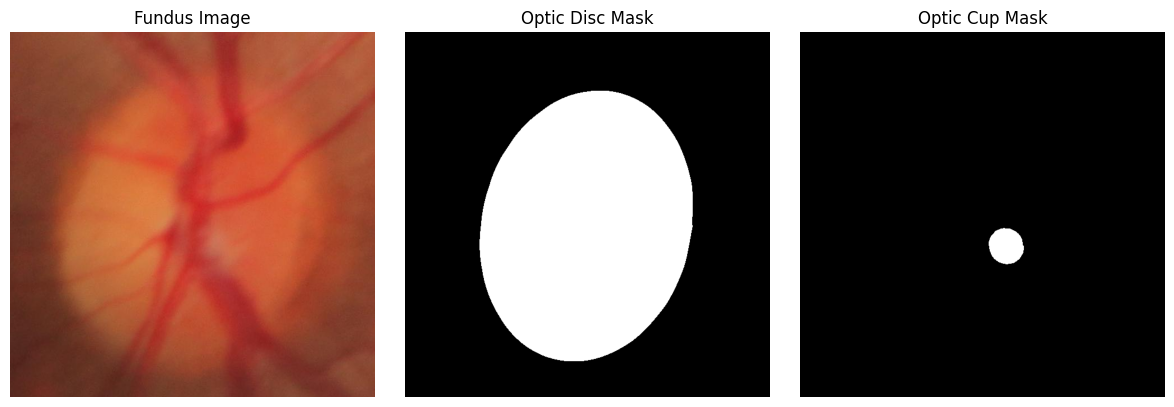

In [48]:
import os
from PIL import Image
import matplotlib.pyplot as plt

img_dir = "partitioned_randomly/images/test"
disc_dir = "partitioned_randomly/masks_disc/test"
cup_dir = "partitioned_randomly/masks_cup/test"

def get_base_name(file):
    # Remove extensions and suffixes like -1
    return file.split("-")[0] if "-1" in file else file.replace(".png", "")

valid_samples = []

img_files = [f for f in os.listdir(img_dir) if f.endswith(".png")]
for img_file in img_files:
    base = img_file.replace(".png", "")
    disc_mask = f"{base}-1-Disc-T.png"
    cup_mask = f"{base}-1-Cup-T.png"

    if os.path.exists(os.path.join(disc_dir, disc_mask)) and os.path.exists(os.path.join(cup_dir, cup_mask)):
        valid_samples.append(base)

print("Found valid samples:", len(valid_samples))
print("Showing one sample:", valid_samples[0] if valid_samples else "None")

if valid_samples:
    sample_name = valid_samples[0]
    image = Image.open(os.path.join(img_dir, sample_name + ".png"))
    disc_mask = Image.open(os.path.join(disc_dir, sample_name + "-1-Disc-T.png"))
    cup_mask = Image.open(os.path.join(cup_dir, sample_name + "-1-Cup-T.png"))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Fundus Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Optic Disc Mask")
    plt.imshow(disc_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Optic Cup Mask")
    plt.imshow(cup_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No matching image-mask pairs found.")


In [49]:
import os

train_images = os.listdir("partitioned_randomly/images/train")
print("r1_Im004.png" in train_images)

print([f for f in train_images if "004" in f])


True
['r1_Im004.png', 'r2_Im004.png']


In [50]:
from evaluate import evaluate_model

dice_disc, dice_cup = evaluate_model()

print(f"Dice Coefficient (Optic Disc): {dice_disc:.4f}")
print(f"Dice Coefficient (Optic Cup):  {dice_cup:.4f}")


Matched image + disc + cup samples: 101
Example base names: ['r2_Im226', 'r2_Im024', 'r2_Im150', 'r2_Im144', 'r2_Im408']
Dice Coefficient (Optic Disc): 0.9337
Dice Coefficient (Optic Cup):  0.5959


In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import FileLink, display

def keep_largest_contour(mask: np.ndarray) -> np.ndarray:
    """Keeps only the largest contour in a binary mask."""
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros_like(mask, dtype=np.uint8)

    largest = max(contours, key=cv2.contourArea)
    cleaned = np.zeros_like(mask, dtype=np.uint8)
    cv2.drawContours(cleaned, [largest], -1, 1, thickness=-1)
    return cleaned

def make_overlay(img, gt_disc, gt_cup, pr_disc, pr_cup, dice_d, dice_c):
    img = img.squeeze(0).permute(1, 2, 0).numpy()
    overlay = (img * 255).astype(np.uint8).copy()

    fig, ax = plt.subplots(figsize=(6, 6))

    # Clean and draw only largest region
    for mask, color in [(pr_disc.squeeze().numpy() > 0.5, (255, 0, 0)),   # Red = disc
                        (pr_cup.squeeze().numpy() > 0.5, (0, 0, 255))]:  # Blue = cup
        cleaned = keep_largest_contour(mask)
        contours, _ = cv2.findContours(cleaned.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        overlay = cv2.drawContours(overlay, contours, -1, color, 2)

    ax.imshow(overlay)
    ax.set_title(f"Dice Disc: {dice_d:.4f} | Dice Cup: {dice_c:.4f}")
    ax.axis("off")
    return fig


In [ ]:
pdf_filename = "optic_disc_cup_overlays.pdf"
with PdfPages(pdf_filename) as pdf:
    for k in range(len(imgs)):
        fig = make_overlay(imgs[k], gt_disc[k], gt_cup[k], pr_disc[k], pr_cup[k], d_dice[k], c_dice[k])
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF '{pdf_filename}' generated with {len(imgs)} samples.")
display(FileLink(pdf_filename, result_html_prefix="Click to download: "))